元の結果: {'11': 1000}
変換後の結果: {'11': 1000}


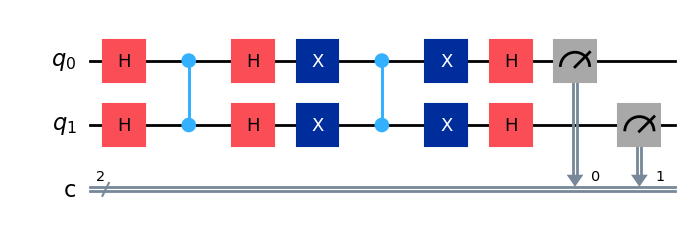

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram

'''
グローバーのアルゴリズム（Grover’s algorithm）は、量子コンピュータで動作する 検索アルゴリズム です。
特に、非構造化データベース（例：リストや配列）から特定の要素を見つけるために使用されます。
古典コンピュータでは𝑂(𝑁)（線形時間）かかる検索を、量子コンピュータでは 二乗根時間で実行できるという特長があります。

アルゴリズムの手順:
グローバーのアルゴリズムは、次のような手順で動作します。
ステップ 1: 初期化
  ・𝑁個の要素を持つデータベースを、量子ビットの状態としてエンコードする。
  ・量子ビットを すべての状態の重ね合わせ にする（アダマール変換を適用）。
ステップ 2: オラクル（Oracle）
  ・「目的の要素かどうかを判定する関数」をオラクル と呼ぶ。
  ・このオラクルは、正解の要素に対して 位相反転（−1を掛ける）を行う。
ステップ 3: 振幅増幅（Amplitude Amplification）
  ・グローバー拡散（Grover Diffusion）と呼ばれる変換を適用し、正解の確率振幅を増幅する。
  ・具体的には、全体の平均から各状態を対称に反転させる操作を行う。
ステップ 4: 繰り返し
  ・上記の オラクルと振幅増幅 を繰り返す。
    グローバーのアルゴリズムでは、適切な回数（k≒𝜋/4×√𝑁回）の繰り返しを導入することで、ターゲットの確率が最大化される。
    解がK個なら、（k≒𝜋/4×√(𝑁/K)回）
  ・これにより、正解の確率が非常に高くなる。
ステップ 5: 測定
  量子状態を測定し、正解の要素を取得する。

このコードでは、オラクルの部分で |11⟩ の位相を反転 しています。
circuit.cz(0, 1)
は、1/2*(∣00⟩+∣01⟩+∣10⟩+∣11⟩)の∣11⟩を移送反転し、1/2*(∣00⟩+∣01⟩+∣10⟩-∣11⟩)にします。
'''


################
#### 修正前
################
# 量子ビットのレジスタを作成
# q = QuantumRegister(2)
# circuit = QuantumCircuit(q)
# # 回路にゲートを適用
# circuit.h([0,1])
# circuit.cz(0,1)
# circuit.h([0,1])
# circuit.x([0,1])
# circuit.cz(0,1)
# circuit.x([0,1])
# circuit.h([0,1])
# circuit.measure_all()


################
#### 修正後1
################
# # 量子ビットの数
# n = 2
# # グローバーのアルゴリズムを適用する回数（√(2^n)回）
# iterations = int(np.pi / 4 * np.sqrt(2**n))
# # 量子回路を作成
# circuit = QuantumCircuit(n, n)



# # **1. すべての量子ビットを均等な重ね合わせ状態にする**
# circuit.h(range(n))
# # グローバーの繰り返し
# for _ in range(iterations):
#     # **2. オラクル: 検索対象の状態 |11⟩ の位相を反転**
#     circuit.cz(0, 1)

#     # **3. 振幅増幅**
#     circuit.h(range(n))
#     circuit.x(range(n))
#     circuit.cz(0, 1)
#     circuit.x(range(n))
#     circuit.h(range(n))

# # **4. 測定**
# circuit.measure(range(n), range(n))


################
#### 修正後2
################
# 測定結果のビット順を逆順に変換する関数
def reverse_bit_order(counts):
    return {key[::-1]: value for key, value in counts.items()}

# 2量子ビット用オラクル
def apply_oracle_2q(circuit, target):
    '''
    target: "00", "01", "10", "11" のいずれか
    ターゲット状態を |11> に変換するため、target で '0' である位置に X ゲートを適用し、
    CZ ゲートで位相反転、再び X ゲートで元に戻す。
    '''
    for i, bit in enumerate(target):
        if bit == '0':
            circuit.x(i)
    circuit.cz(0, 1)
    for i, bit in enumerate(target):
        if bit == '0':
            circuit.x(i)

# 2量子ビット用拡散オペレーター（振幅増幅）
def apply_diffusion_2q(circuit):
    '''
    拡散オペレーターは以下の操作で実装する：
      H → X → CZ → X → H
    '''
    circuit.h([0,1])
    circuit.x([0,1])
    circuit.cz(0, 1)
    circuit.x([0,1])
    circuit.h([0,1])

# 2量子ビット版グローバーのアルゴリズム
def grover_2q(target):
    n = 2
    # n=2 の場合、最適反復回数は π/4 * √(2^2) = π/2 ≒ 1
    iterations = int(np.pi / 4 * np.sqrt(2**n))
    circuit = QuantumCircuit(n, n)
    
    # 初期化：すべての状態の重ね合わせ
    circuit.h([0,1])
    
    # オラクルと拡散オペレーターを反復適用
    for _ in range(iterations):
        apply_oracle_2q(circuit, target)
        apply_diffusion_2q(circuit)
    
    # 測定（Qiskit はビッグエンディアンで結果を返す）
    circuit.measure([0,1], [0,1])
    return circuit

# ターゲット状態を指定（ここでは直感的に "10" を求める）
target = "11"
circuit = grover_2q(target)



# AerSimulatorを使用してシミュレーション
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()

# # 結果を取得して表示
# counts = result.get_counts(circuit)
# print(counts)

counts = result.get_counts()

# ビット順を逆順に変換して表示（これで target "10" が "10" と表示される）
reversed_counts = reverse_bit_order(counts)
print("元の結果:", counts)
print("変換後の結果:", reversed_counts)
plot_histogram(reversed_counts)
plt.show()


# 回路図を描画
circuit.draw(output='mpl')

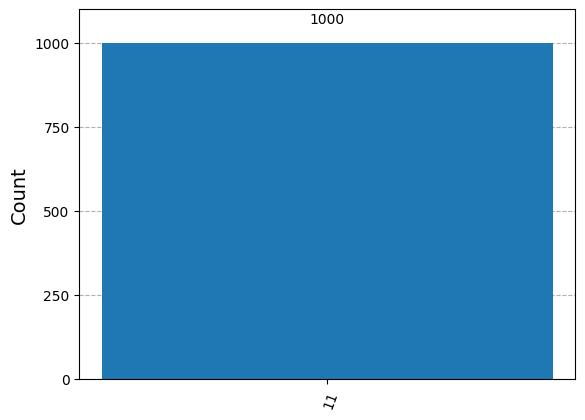

In [63]:
# plot_histogram(counts)
plot_histogram(reversed_counts)